## Python programs

 - Storm event CG flash density fields at ~.25 km grid resolution and 5 minute time resolution.  2D Gaussian distribution of each CG flash.  
 - Storm tracking for CG flash density fields. 

The first step is making these ~.25km 5min grid slices. We will be using just one day of data for these and we already know the top days so we will look at that one first. 

In [1]:
from region import *
from plotting import *
%matplotlib inline

In [4]:
c = Region(city=cities['cedar'])
c.get_top(10)

2014-09-26 12:00:00    91884
2014-09-27 12:00:00    90627
2015-08-30 12:00:00    66916
2014-08-12 12:00:00    65613
2015-07-08 12:00:00    63068
2015-07-01 12:00:00    62599
2013-08-17 12:00:00    62191
2014-08-26 12:00:00    58833
2014-07-15 12:00:00    50065
2015-08-07 12:00:00    48051
dtype: int64

For the first step we will take the whole area at 10km grid cell size and flatten the data along the various axes to see whether there are any that we can get rid of.

In [154]:
c.define_grid(60)
box, tr = c.get_grid_slices('2014-09-26', freq='5min')

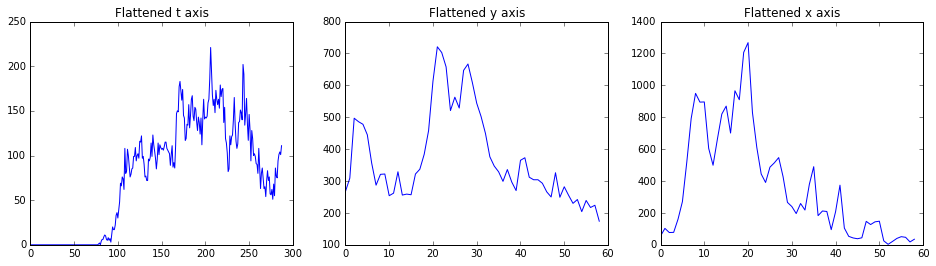

In [155]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

axes[0].plot(np.sum(box, axis=(1,2)))
axes[0].set_title("Flattened t axis");

axes[1].plot(np.sum(box, axis=(0,2)))
axes[1].set_title("Flattened y axis")

axes[2].plot(np.sum(box, axis=(0,1)))
axes[2].set_title("Flattened x axis");

From these flattened shadows of the storm, we can select out the most interesting part of the grid and pump up the resolution. 

In [156]:
c.define_grid(nbins=200, extents=[c.gridx[5], c.gridx[25], c.gridy[15], c.gridy[35]])
box, tr = c.get_grid_slices('2014-09-26', freq='5min')
box = box[100:250,:,:]
tr = tr[100:250]

## Tracking features

In [30]:
from rpy2 import robjects 
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
SpatialVx = importr('SpatialVx')
rsummary = robjects.r.summary

In [44]:
d = {}
X, Y = np.meshgrid(c.gridx[0:-1], c.gridy[0:-1])
ll = np.array([X.flatten('F'), Y.flatten('F')]).T
for i in range(100, 120): #for i in range(box.shape[0]-1):
    hold = SpatialVx.make_SpatialVx(box[i,:,:], box[i+1,:,:], loc=ll)
    look = SpatialVx.FeatureFinder(hold, smoothpar=2, thresh=1, min_size=5)

    try:
        x = rsummary(look, silent=True)[0]
    except:
        continue
    px = pandas2ri.ri2py(x)
    df0 = pd.DataFrame(px, columns=['centroidX', 'centroidY', 'area', 'OrientationAngle', 
                                  'AspectRatio', 'Intensity0.25', 'Intensity0.9'])
    df0['Observed'] = list(df0.index+1)
    m = SpatialVx.centmatch(look, criteria=3, const=10)
    p = pandas2ri.ri2py(m[12])
    df1 = pd.DataFrame(p, columns=['Forecast', 'Observed'])
    l = SpatialVx.FeatureMatchAnalyzer(m)
    try:
        p = pandas2ri.ri2py(rsummary(l, silent=True))
    except:
        continue
    df2 = pd.DataFrame(p, columns=['Partial Hausdorff Distance','Mean Error Distance','Mean Square Error Distance',
                                  'Pratts Figure of Merit','Minimum Separation Distance', 'Centroid Distance',
                                  'Angle Difference','Area Ratio','Intersection Area','Bearing', 'Baddeleys Delta Metric',
                                  'Hausdorff Distance'])
    df3 = df1.join(df2)

    d.update({tr[i]: pd.merge(df0, df3, how='outer')})


In [45]:
p =pd.Panel(d)

In [87]:
df0 = p[120,:,['centroidX', 'centroidY', 'Forecast']].dropna()
df1 = p[121,:,['centroidX', 'centroidY', 'Observed']].dropna()

In [88]:
df0.index = df0['Forecast']
df1.index = df1['Observed']

In [107]:
lines = []
for it in range(p.shape[0]-1):
    df0 = p[it,:,['centroidX', 'centroidY', 'Forecast']].dropna()
    df1 = p[it+1,:,['centroidX', 'centroidY', 'Observed']].dropna()
    df0.index = df0['Forecast']
    df1.index = df1['Observed']
    df = df0.join(df1, lsuffix='_start', rsuffix='_end').dropna(how='any')
    lines.append(df)

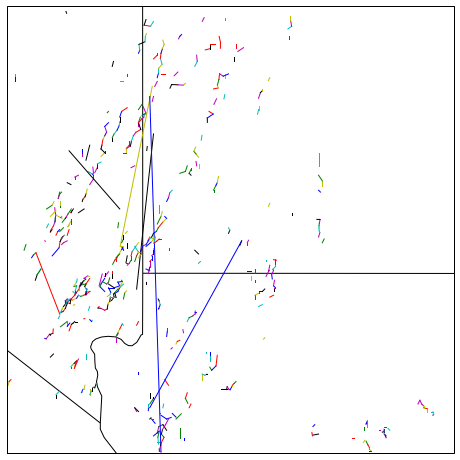

In [146]:
plt.figure(figsize=(8,8))
im, ax = c.plot_grid(box[0], vmin=1, vmax=10)
for i in range(p.shape[0]-1):
    for ifeat in range(lines[i].shape[0]):
        plt.plot(lines[i].iloc[ifeat,[0,3]].values, lines[i].iloc[ifeat,[1,4]].values);
plt.savefig('output/storm paths.png')